<a href="https://githubtocolab.com/BorjaRequena/Neural-Network-Course/blob/master/nbs/course/deep_learning/pytorch_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# PyTorch basics

[PyTorch](https://pytorch.org) is an automatic differentiation framework that, essentially, is your [NumPy](https://numpy.org) for machine learning and anything that involves exact derivatives.
PyTorch natively supports hardware accelerators, such as GPUs, that can significantly speed up matrix multiplication operations, as well as distributed computing to handle large workloads.

The main element of PyTorch is a tensor, which behaves very similarly to NumPy arrays.

In [ ]:
import torch
torch.manual_seed(7)

a_tensor = torch.tensor([1.0, 2.0, 3.0])
b_tensor = torch.tensor([4.0, 5.0, 6.0])
type(a_tensor)

torch.Tensor

We can perform any kind of operations over tensors, from matrix to element-wise operations.

In [ ]:
a_tensor + 3

tensor([4., 5., 6.])

In [ ]:
a_tensor @ b_tensor  # dot product

tensor(32.)

Tensors have `requires_grad` a property that indicates whether gradients should be computed with respect to their values.
By default, this is set to `False`.

In [ ]:
a_tensor.requires_grad

False

However, if we set it to `True`, we will be able to compute the gradient of scalar quantities with respect to the tensor.
Let's consider a simple example where we add the sine and cosine of both tensors:
$$\sum_i\sin(a_i) + \cos(b_i)$$

::: {.callout-note}
# Derivatives
Recall that $\frac{d}{dx}\sin(x) = \cos(x)$ and $\frac{d}{dx}\cos(x) = -\sin(x)$.
:::

In [ ]:
a_tensor.requires_grad = True
b_tensor.requires_grad = True

value = torch.sum(torch.sin(a_tensor) + torch.cos(b_tensor))
value.backward()

The result of the sum, `value`, is also a tensor.
When we call the `backward` method, it computes the gradient over all the tensors that have been involved in its calculation.
The resulting gradients are stored in the tensors themselves. 

In [ ]:
a_tensor.grad, torch.cos(a_tensor)

(tensor([ 0.5403, -0.4161, -0.9900]),
 tensor([ 0.5403, -0.4161, -0.9900], grad_fn=<CosBackward0>))

In [ ]:
b_tensor.grad, -torch.sin(b_tensor)

(tensor([0.7568, 0.9589, 0.2794]),
 tensor([0.7568, 0.9589, 0.2794], grad_fn=<NegBackward0>))

::: {.callout-warning}
## Zero out gradients

Subsequent gradient computations with respect to the same tensor will add the new gradient to the previous one.
We must take this into account and reset the gradients manually when needed. 

:::

Computing the gradient of another quantity with respect to the same tensors will modify its gradient.
Consider the sum of all the entries of $\mathbf{a}$.
The gradient with respect to itself is 1 for every entry.
This value will be added to the previously existing gradient, although $\mathbf{b}$ will not be affected.

In [ ]:
a_sum = torch.sum(a_tensor)
a_sum.backward()

a_tensor.grad, torch.cos(a_tensor) + 1

(tensor([1.5403, 0.5839, 0.0100]),
 tensor([1.5403, 0.5839, 0.0100], grad_fn=<AddBackward0>))

In [ ]:
b_tensor.grad

tensor([0.7568, 0.9589, 0.2794])

To reset the gradients of a tensor, we can manually set them to `None` or zero.

In [ ]:
a_tensor.grad.zero_()
b_tensor.grad = None

::: {.callout-note}
In machine learning applications, we hardly ever zero out gradients at the tensor level.
We typically rely on the `zero_grad()` method from either our [optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Optimizer) or [module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) to reset the gradients.
See [the docs](https://pytorch.org/tutorials/recipes/recipes/zeroing_out_gradients.html) for further details.
::: 

# A fully-connected neural network from scratch

With these basic tools, we are ready to build a neural network!
As we saw in the [introductory lesson](https://borjarequena.github.io/Neural-Network-Course/course/introduction.html), in order to have a learning system we need a task, a performance metric, data, and a model.

## Task and data

Let's start by the task and the data.
We will use the MNIST dataset, which is composed of hand-written digit images from 0 to 9.
The task will be to classify those images into their respective digits.

In [ ]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split


mnist_train = MNIST(root="data", train=True, download=True, transform=ToTensor())
mnist_test = MNIST(root="data", train=False, download=True, transform=ToTensor())

print(mnist_train)
print(mnist_test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In machine learning, it is very important that we become familiar with the data that we are dealing with.
In this case, we may plot some example images.

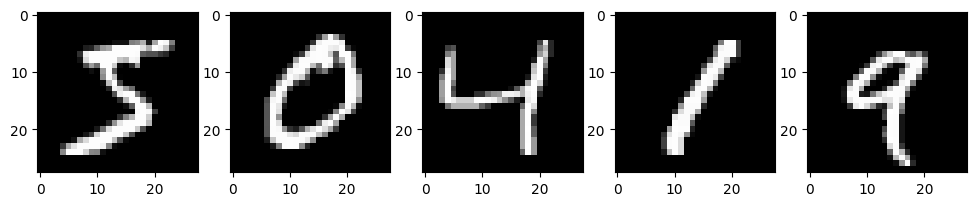

In [ ]:
#| code-fold: true
import matplotlib.pyplot as plt

def plot_image(ax, image: torch.Tensor, label: int | None = None):
    "Plot a single image."
    ax.imshow(image.squeeze(), cmap="gray")
    if label is not None:
        ax.set_title(f"Pred: {label}")

def plot_examples(dataset):
    "Plot 5 examples from the MNIST dataset."
    _, axes = plt.subplots(1, 5, figsize=(12, 3))
    for i, ax in enumerate(axes):
        image, label = dataset[i]
        plot_image(ax, image)
    plt.show()

plot_examples(mnist_train)

The images are $28 \times 28$ pixels in grayscale, and the labels are a single scalar.

In [ ]:
image, label = mnist_train[0]
image.shape, label

(torch.Size([1, 28, 28]), 5)

Now let's split the training set into training and validation.
This will allow us to evaluate the model's generalization capabilities during training and tune its hyper-parameters.

In [ ]:
train_data, validation_data = random_split(mnist_train, [55000, 5000])

Finally, we will create the data loaders for the training, validation, and testing data sets.
These objects will take care of spliting the data into batches, given that 60000 images may be too much to process at once.

In [ ]:
batch_size = 128
train_loader = DataLoader(train_data, batch_size, shuffle=True)
val_loader = DataLoader(validation_data, batch_size, shuffle=False)
test_loader = DataLoader(mnist_test, batch_size, shuffle=False)

## Performance measure

In order to train any model, we need to be able to evalute its performance on the given task.
This performance measure must be a smooth function that is typically referred to as **loss function**.
The learning process will aim to minimize the loss function, as introduced in the [learning as an optimization task](https://borjarequena.github.io/Neural-Network-Course/course/introduction.html#learning-as-an-optimization-task) section from the introductory chapter.

In this case, we have a classification problem with ten classes (digits from 0 to 9).
Therefore, we will use the cross-entropy loss function $$\mathcal{L}_{\text{CE}} = -\frac{1}{n}\sum_i^n \mathbf{y}_i^T\log(f(\mathbf{x}_i))\,,$$ where $\mathbf{y}_i$ is the one-hot-encoding vector of the true label, and $f(\mathbf{x}_i)$ provides the predicted probability for sample $\mathbf{x}_i$ to belong to each of the classes.

In [ ]:
def cross_entropy_loss(predictions, targets):
    """Compute the cross-entropy loss between predictions and targets for a given batch."""
    target_preds = predictions[torch.arange(len(predictions)), targets]
    return -torch.mean(torch.log(target_preds))

Besides the loss function, we can compute other performance indicators that may not need to be differentiable, like the accuracy or the error rate. 

In [ ]:
def accuracy(predictions, targets):
    """Compute the accuracy of predictions given the true targets."""
    return (predictions.argmax(dim=1) == targets).float().mean()

## Model

The last ingredient for our learning task is a model that will encode the program to solve the task.
In this case, we will start with a simple **fully-connected neural network**.
In these networks, we distinguish between three types of layers:

- The *input layer* contains the data values. In this case, it will be the pixel values.
- The *output layer* contains the desired output. In this case, the probability for each class.
- The *hidden layers* are all the layers between the input and output layers.

Individual neurons perform simple calculations based on the signal received from by the neurons from the preceding layer.
Typically, they perform a linear transformation followed by a non-linear *activation function* $\xi$ of the form.
\begin{split}
    z &= \mathbf{\omega}^T \mathbf{x} + b = \sum_i \omega_i x_i + b\\
    x &= \xi(z)\,.
\end{split}
Here, $\mathbf{x}$ denotes the activations of the neurons in the preceding layer, and the connection strength between each of those neurons is encoded in the *weight* vector $\mathbf{\omega}$.
The neuron incorporates a bias $b$, and the resulting value of the linear transformation $z$ is known as the *logit*.
Finally, the resulting activation of the neuron $x$ is determined by applying the non-linear activation function $\xi$.

We will start by initializing the parameters for our linear operations.

In [ ]:
input_size = 28 * 28
hidden_size = 500
n_classes = 10

# Input to hidden
W1 = torch.randn(input_size, hidden_size) / torch.sqrt(torch.tensor(input_size))
W1.requires_grad_()
b = torch.zeros(hidden_size, requires_grad=True)

# Hidden to output
W2 = torch.randn(hidden_size, n_classes) / torch.sqrt(torch.tensor(hidden_size))
W2.requires_grad_();

The activation functions can take any form, so long as it is non-linear, and they can be used to obtain the desired output.
In this case, we will use the rectified linear unit (ReLU) activation function in the hidden layer $$\text{ReLU}(z) = \max(0, z)\,,$$ and a softmax activation function in the output layer to normalize the logits as a probability distribution $$\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_k e^{z_k}}\,.$$

In [ ]:
def relu(x):
    "Rectified linear unit activation function."
    return torch.maximum(x, torch.tensor(0.0))

def softmax(x):
    "Softmax activation function."
    return torch.exp(x) / torch.exp(x).sum(axis=-1, keepdim=True)

Now we can define our model.

In [ ]:
def model(x):
    "Neural network model."
    x = x.reshape(-1, 28 * 28)  # Flatten the image
    z = x @ W1 + b  # First linear transformation
    x = relu(z)  # Hidden layer activation
    z = x @ W2  # Second linear transformation
    return softmax(z)  # Output layer activation

## Training

We have all the necessary ingredients to train a machine learning model for digit recognition.
Let's put everything together in a training loop.

The typical learning procedure is:

1. For every training batch
    - Evaluate the model
    - Compute the loss
    - Compute the gradients of the parameters
    - Update the parameters

2. For every validation batch
    - Evaluate the model
    - Compute the loss

3. Repeat 1 and 2 for every training epoch

In [ ]:
learning_rate = 0.1
n_epochs = 40

training_loss = []
validation_loss = []

for _ in range(n_epochs):
    epoch_loss = 0
    for images, labels in train_loader:
        preds = model(images)
        loss = cross_entropy_loss(preds, labels)
        loss.backward()

        # Gradient descent step
        with torch.no_grad():
            # Update parameters
            W1 -= W1.grad * learning_rate
            b -= b.grad * learning_rate
            W2 -= W2.grad * learning_rate
            # Reset gradients
            W1.grad.zero_()
            b.grad.zero_()
            W2.grad.zero_()

        epoch_loss += loss.item()

    training_loss.append(epoch_loss / len(train_loader))

    with torch.no_grad():
        epoch_loss = 0
        val_preds, val_targets = [], []
        for images, labels in val_loader:
            preds = model(images)
            loss = cross_entropy_loss(preds, labels)
            
            epoch_loss += loss.item()
            val_preds.append(preds)
            val_targets.append(labels)

        val_acc = accuracy(torch.cat(val_preds), torch.cat(val_targets))
        validation_loss.append(epoch_loss / len(val_loader))

    print(f"Training Loss: {training_loss[-1]:.4f}, Validation Loss: {validation_loss[-1]:.4f}, Accuracy: {val_acc:.4f}")

Training Loss: 0.4941, Validation Loss: 0.3285, Accuracy: 0.9156
Training Loss: 0.2658, Validation Loss: 0.2582, Accuracy: 0.9346
Training Loss: 0.2140, Validation Loss: 0.2177, Accuracy: 0.9460
Training Loss: 0.1793, Validation Loss: 0.1871, Accuracy: 0.9528
Training Loss: 0.1548, Validation Loss: 0.1684, Accuracy: 0.9564
Training Loss: 0.1362, Validation Loss: 0.1526, Accuracy: 0.9622
Training Loss: 0.1211, Validation Loss: 0.1360, Accuracy: 0.9658
Training Loss: 0.1090, Validation Loss: 0.1302, Accuracy: 0.9664
Training Loss: 0.0988, Validation Loss: 0.1156, Accuracy: 0.9684
Training Loss: 0.0900, Validation Loss: 0.1139, Accuracy: 0.9700
Training Loss: 0.0831, Validation Loss: 0.1086, Accuracy: 0.9718
Training Loss: 0.0767, Validation Loss: 0.1035, Accuracy: 0.9722
Training Loss: 0.0712, Validation Loss: 0.1023, Accuracy: 0.9732
Training Loss: 0.0662, Validation Loss: 0.0955, Accuracy: 0.9742
Training Loss: 0.0618, Validation Loss: 0.0953, Accuracy: 0.9730
Training Loss: 0.0579, Va

<matplotlib.legend.Legend>

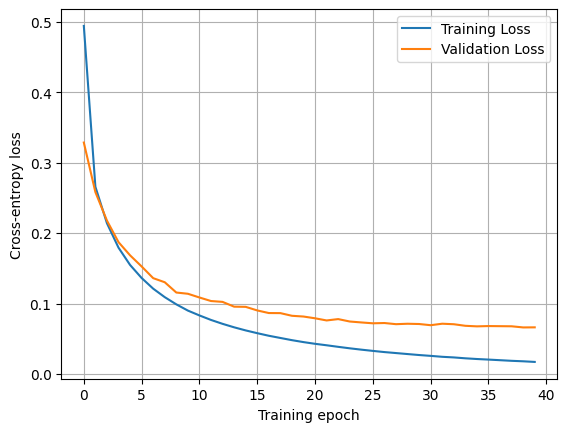

In [ ]:
plt.plot(training_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.xlabel("Training epoch")
plt.ylabel("Cross-entropy loss")
plt.grid()
plt.legend()

# Deep learning à la torch

PyTorch offers a compact suite to define and train neural networks.
The main elements are [`Module`s](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module), [functionals](https://pytorch.org/docs/stable/nn.functional.html), and [optimizers](https://pytorch.org/docs/stable/optim.html).

Let's implement the same neural network as before using the tools provided by torch, starting by the architecture.
Neural networks in torch must inherit from the `Module` class and implement a `forward` method.
The `Module` class takes care of implementing a reciprocal `backward` method for us.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class FullyConnected(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear_1 = nn.Linear(input_size, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, output_size, bias=False)
        
    def forward(self, x):
        x = x.reshape(-1, 28 * 28)
        z = self.linear_1(x)
        x = F.relu(z)
        z = self.linear_2(x)
        return z  # Notice we do not implement the softamx activation
    
model = FullyConnected(28 * 28, 500, 10)

Notice that we have not implemented the last activation function in the output layer.
This is because PyTorch's cross entropy loss expects the logits, as it implements an optimized calculation for the loss.
See [the docs](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) for further details.

To train the model, we will use the stochastic gradient descent optimizer, in order to faithfully reproduce the results.

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Finally, we can write the training loop.

In [ ]:
training_loss = []
validation_loss = []

for _ in range(n_epochs):
    epoch_loss = 0
    for images, labels in train_loader:
        logits = model(images)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()

    training_loss.append(epoch_loss / len(train_loader))

    with torch.no_grad():
        epoch_loss = 0
        val_preds, val_targets = [], []
        for images, labels in val_loader:
            logits = model(images)
            loss = F.cross_entropy(logits, labels)

            epoch_loss += loss.item()
            val_preds.append(F.softmax(logits, dim=1))
            val_targets.append(labels)

        val_acc = accuracy(torch.cat(val_preds), torch.cat(val_targets))
        validation_loss.append(epoch_loss / len(val_loader))

    print(f"Training Loss: {training_loss[-1]:.4f}, Validation Loss: {validation_loss[-1]:.4f}, Accuracy: {val_acc:.4f}")

Training Loss: 0.5788, Validation Loss: 0.3580, Accuracy: 0.9054
Training Loss: 0.2900, Validation Loss: 0.2896, Accuracy: 0.9260
Training Loss: 0.2362, Validation Loss: 0.2396, Accuracy: 0.9402
Training Loss: 0.1995, Validation Loss: 0.2137, Accuracy: 0.9488
Training Loss: 0.1728, Validation Loss: 0.1875, Accuracy: 0.9506
Training Loss: 0.1516, Validation Loss: 0.1732, Accuracy: 0.9554
Training Loss: 0.1351, Validation Loss: 0.1541, Accuracy: 0.9596
Training Loss: 0.1214, Validation Loss: 0.1442, Accuracy: 0.9618
Training Loss: 0.1098, Validation Loss: 0.1348, Accuracy: 0.9650
Training Loss: 0.1008, Validation Loss: 0.1249, Accuracy: 0.9690
Training Loss: 0.0920, Validation Loss: 0.1208, Accuracy: 0.9672
Training Loss: 0.0850, Validation Loss: 0.1149, Accuracy: 0.9702
Training Loss: 0.0788, Validation Loss: 0.1051, Accuracy: 0.9722
Training Loss: 0.0733, Validation Loss: 0.1041, Accuracy: 0.9716
Training Loss: 0.0686, Validation Loss: 0.0998, Accuracy: 0.9718
Training Loss: 0.0641, Va

<matplotlib.legend.Legend>

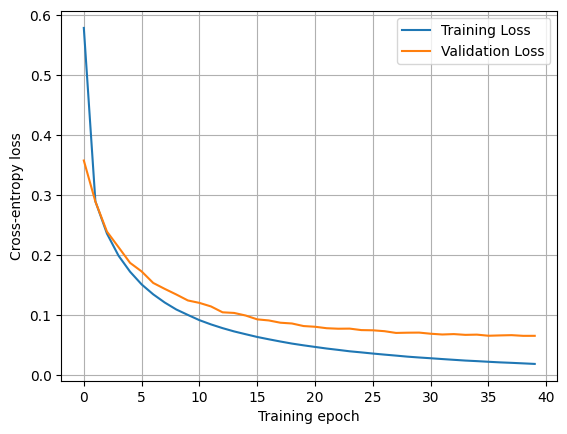

In [ ]:
plt.plot(training_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.xlabel("Training epoch")
plt.ylabel("Cross-entropy loss")
plt.grid()
plt.legend()